##**Business Objectives**
* This case study aims to identify patterns which indicate if a client has difficulty paying their installments which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc. This will ensure that the consumers capable of repaying the loan are not rejected. Identification of such applicants using EDA is the aim of this case study.
 
* In other words, the company wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default.  The company can utilise this knowledge for its portfolio and risk assessment.
* To develop your understanding of the domain, you are advised to independently research a little about risk analytics - understanding the types of variables and their significance should be enough).


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
path = "/content/drive/MyDrive/Advance Analytic Stats/"

# 1. Reading and understanding the data

## 1.1 importing the dataset

In [15]:
file_name = "previous_application.csv"
prev_ap_df = pd.read_csv(f"{path}/{file_name}", encoding='cp1252')
file_name = "application_data (1).csv"
application_df = pd.read_csv(f"{path}/{file_name}", encoding='cp1252')

###checking 5 rows for dataset

In [16]:
prev_ap_df.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2 Understanding the data

In [17]:
prev_ap_df.shape

(1670214, 37)

###previous application dataset have 1670214 rows and 37 columns.

###Now we are checking information of the previous application dataset

In [18]:
prev_ap_df.info('all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

###* prev_ap_df contains 37 features and 1670214 rows
(Out of which 15 features are float64, 6 features are integer, 16 features are object datatype)

In [19]:
# Additional columns and common columns in application_df and prev_ap_df
additional_feat = []
common_feat = []

for col in application_df.columns:
    if col not in prev_ap_df.columns:
        additional_feat.append(col)
    else:
        common_feat.append(col)
        
print(len(additional_feat))
print(len(common_feat))
print(common_feat)

114
8
['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START']


###Insight:

SK_ID_CURR is an unique identifier, which will use to merge the relevant columns of 2 dataframes

##Data Cleaning

In [20]:
# Function_name : missingdata_percentage
# Usage : Returns % of missing values for all features in a DataFrame
# Arguments : dataframe
# Returns : a dataframe containing categories having missing values and % of missing values in those categories

def missingdata_percentage(df):
    missing = pd.DataFrame(columns=['category','percentage'])
    for col in df.columns:
        if df[col].isna().values.any():
            percentage = 100*df[col].isna().sum()/df.shape[0]
            missing = missing.append({'category' : col, 'percentage' : percentage}, ignore_index=True)
    return missing
missingdata_prev = missingdata_percentage(prev_ap_df)


###Now we are first arrage the columns in descending order which has highest null values 

In [21]:
missingdata_prev.sort_values('percentage', ascending=False)

,category,percentage
5,RATE_INTEREST_PRIMARY,99.643698
6,RATE_INTEREST_PRIVILEGED,99.643698
2,AMT_DOWN_PAYMENT,53.636480
4,RATE_DOWN_PAYMENT,53.636480
7,NAME_TYPE_SUITE,49.119754
10,DAYS_FIRST_DRAWING,40.298129
11,DAYS_FIRST_DUE,40.298129
12,DAYS_LAST_DUE_1ST_VERSION,40.298129
13,DAYS_LAST_DUE,40.298129
14,DAYS_TERMINATION,40.298129


###Observation: There are 16 features in prev_app_df that have missing values.

Permanently dropping the features (RATE_INTEREST_PRIMARY and RATE_INTEREST_PRIVILEGED) as 99% data is missing.

Dropping rows containing missing values for the features(AMT_CREDIT and PRODUCT_COMBINATION) for very low % of missing data.

In [22]:
prev_ap_df.drop(['RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED'], axis=1, inplace=True)
prev_ap_df.dropna(subset=['AMT_CREDIT','PRODUCT_COMBINATION'], inplace=True)

#Checking the remaining columns
prev_ap_df

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


###Extracting the numeric features from previous application data

In [23]:
numeric_features = []
for col in prev_ap_df.columns:
    if prev_ap_df[col].dtype == float or prev_ap_df[col].dtype == int:
        numeric_features.append(col)
        
print(numeric_features)

['SK_ID_PREV', 'SK_ID_CURR', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']


We are make one dataframe **prev_num_df** from **prev_ap_df** which has numeric features.

In [24]:
prev_num_df = pd.DataFrame()

for col in numeric_features:
    prev_num_df[col] = prev_ap_df[col]


#information of the new created dataframe prev_num_df.info()
prev_num_df.info()

#prev_num_df have 13 float datatype and 6 int datatype

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1669867 entries, 0 to 1670213
Data columns (total 19 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   SK_ID_PREV                 1669867 non-null  int64  
 1   SK_ID_CURR                 1669867 non-null  int64  
 2   AMT_ANNUITY                1297978 non-null  float64
 3   AMT_APPLICATION            1669867 non-null  float64
 4   AMT_CREDIT                 1669867 non-null  float64
 5   AMT_DOWN_PAYMENT           774370 non-null   float64
 6   AMT_GOODS_PRICE            1284699 non-null  float64
 7   HOUR_APPR_PROCESS_START    1669867 non-null  int64  
 8   NFLAG_LAST_APPL_IN_DAY     1669867 non-null  int64  
 9   RATE_DOWN_PAYMENT          774370 non-null   float64
 10  DAYS_DECISION              1669867 non-null  int64  
 11  SELLERPLACE_AREA           1669867 non-null  int64  
 12  CNT_PAYMENT                1297983 non-null  float64
 13  DAYS_FIRST_D

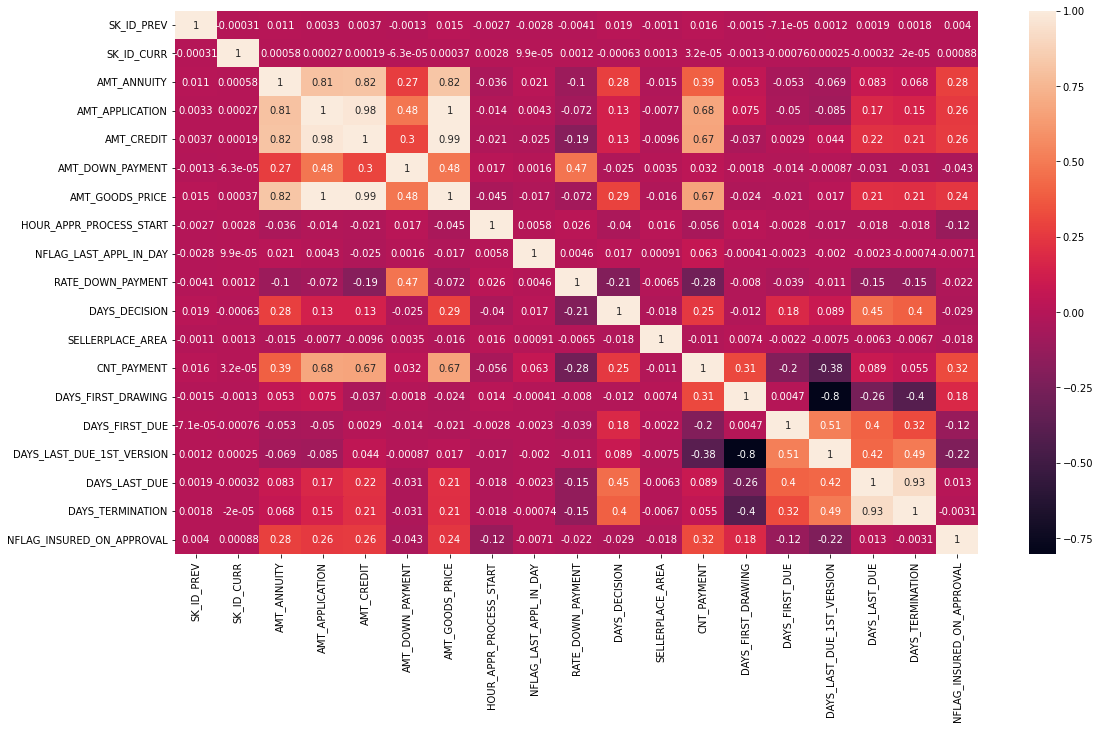

In [26]:
# Checking correlation between numeric features of previous application data

plt.figure(figsize=(18,10))
sns.heatmap(prev_num_df.corr(), annot=True)
plt.show()

###**Insight**:

* '**DAYS_LAST_DUE**' and '**DAYS_TERMINATION**' are highly correlated
* '**DAYS_FIRST_DRAWING**' and '**DAYS_LAST_DUE_1st_VERSION**' have high negative correlation
* '**AMT_ANNUITY**','**AMT_APPLICATION**','**AMT_CREDIT**','AMT_GOODS_PRICE' are highly correlated

###The features can be removed before modelling this data, as they would cause collinearity 

###'**DAYS_TERMINATION**','**DAYS_LAST_DUE_1st_VERSION**','**AMT_APPLICATION**','**AMT_CREDIT**','**AMT_GOODS_PRICE**' For EDA purpose we are not removing them.

In [28]:
prev_ap_df.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
print(prev_ap_df['NAME_TYPE_SUITE'].value_counts())

#we are seeing count of the people 

Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Other_A              9077
Group of people      2240
Name: NAME_TYPE_SUITE, dtype: int64


In [63]:
# Filling missing value as 'Unaccompanied' as most common value

prev_ap_df['NAME_TYPE_SUITE'].fillna(prev_ap_df.NAME_TYPE_SUITE.mode()[0], inplace=True)
print(prev_ap_df['NAME_TYPE_SUITE'].value_counts())

Unaccompanied      1329028
Family              213263
Spouse, partner      67069
Children             31566
Other_B              17624
Other_A               9077
Group of people       2240
Name: NAME_TYPE_SUITE, dtype: int64


In [30]:
# Merging only required columns of application_data with previous_application_data

prev_ap_merged = pd.merge(application_df[['SK_ID_CURR', 'TARGET']], prev_ap_df, how='left', on=['SK_ID_CURR'])

prev_ap_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1429841 entries, 0 to 1429840
Data columns (total 36 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_CURR                   1429841 non-null  int64  
 1   TARGET                       1429841 non-null  int64  
 2   SK_ID_PREV                   1413387 non-null  float64
 3   NAME_CONTRACT_TYPE           1413387 non-null  object 
 4   AMT_ANNUITY                  1106482 non-null  float64
 5   AMT_APPLICATION              1413387 non-null  float64
 6   AMT_CREDIT                   1413387 non-null  float64
 7   AMT_DOWN_PAYMENT             664161 non-null   float64
 8   AMT_GOODS_PRICE              1094176 non-null  float64
 9   WEEKDAY_APPR_PROCESS_START   1413387 non-null  object 
 10  HOUR_APPR_PROCESS_START      1413387 non-null  float64
 11  FLAG_LAST_APPL_PER_CONTRACT  1413387 non-null  object 
 12  NFLAG_LAST_APPL_IN_DAY       1413387 non-n

In [31]:
# Checking on the numeric data

prev_ap_merged.describe()

,SK_ID_CURR,TARGET,SK_ID_PREV,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.429841e+06,1.429841e+06,1.413387e+06,1.106482e+06,1.413387e+06,1.413387e+06,6.641610e+05,1.094176e+06,1.413387e+06,1.413387e+06,664161.000000,1.413387e+06,1.413387e+06,1.106487e+06,852595.000000,852595.000000,852595.000000,852595.000000,852595.000000,852595.000000
mean,2.784721e+05,8.621658e-02,1.922745e+06,1.583720e+04,1.752825e+05,1.963976e+05,6.655317e+03,2.264512e+05,1.247888e+01,9.964313e-01,0.080175,-8.804742e+02,3.150476e+02,1.605195e+01,342257.656710,13488.741567,33274.831806,76665.634755,82353.171672,0.330572
std,1.028026e+05,2.806837e-01,5.327182e+05,1.472491e+04,2.936432e+05,3.195033e+05,2.062030e+04,3.159376e+05,3.331533e+00,5.963220e-02,0.107784,7.835932e+02,7.695935e+03,1.456674e+01,88832.266598,71650.147146,106161.775933,149704.716371,153537.064274,0.470419
min,1.000020e+05,0.000000e+00,1.000001e+06,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.893620e+05,0.000000e+00,1.461345e+06,6.257880e+03,1.975500e+04,2.491200e+04,0.000000e+00,4.982850e+04,1.000000e+01,1.000000e+00,0.000000,-1.314000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1630.000000,-1244.000000,-1316.000000,-1269.000000,0.000000
50%,2.789590e+05,0.000000e+00,1.922706e+06,1.122376e+04,7.090200e+04,8.064000e+04,1.791000e+03,1.102455e+05,1.200000e+01,1.000000e+00,0.062489,-5.820000e+02,4.000000e+00,1.200000e+01,365243.000000,-825.000000,-358.000000,-534.000000,-494.000000,0.000000
75%,3.675110e+05,0.000000e+00,2.384020e+06,2.042111e+04,1.800000e+05,2.156400e+05,7.695000e+03,2.295000e+05,1.500000e+01,1.000000e+00,0.108912,-2.710000e+02,8.500000e+01,2.400000e+01,365243.000000,-408.000000,135.000000,-73.000000,-42.000000,1.000000
max,4.562550e+05,1.000000e+00,2.845381e+06,4.180581e+05,5.850000e+06,4.509688e+06,3.060045e+06,5.850000e+06,2.300000e+01,1.000000e+00,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


###**Insight**: Not dropping the rest of columns with missing values, will use them for further analysis.

##Handling Outliers

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


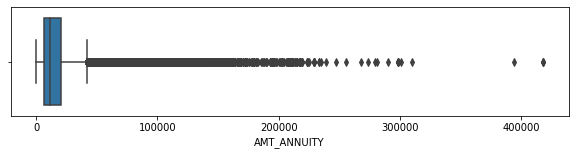

In [32]:
plt.figure(figsize=(10,2))
sns.boxplot(prev_ap_merged['AMT_ANNUITY'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


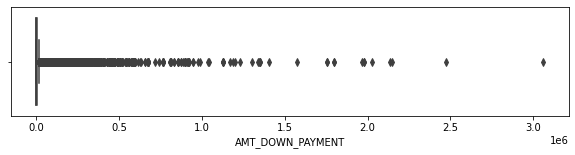

In [33]:
plt.figure(figsize=(10,2))
sns.boxplot(prev_ap_merged['AMT_DOWN_PAYMENT'])
plt.show()

In [34]:
# Excluding values outside 99 percentile for AMT_ANNUITY and AMT_DOWN_PAYMENT

prev_ap_merged = prev_ap_merged[prev_ap_merged['AMT_ANNUITY'] < np.nanpercentile(prev_ap_merged['AMT_ANNUITY'], 99)]
prev_ap_merged = prev_ap_merged[prev_ap_merged['AMT_DOWN_PAYMENT'] < np.nanpercentile(prev_ap_merged['AMT_DOWN_PAYMENT'], 99)]

###Checking the features after updating.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


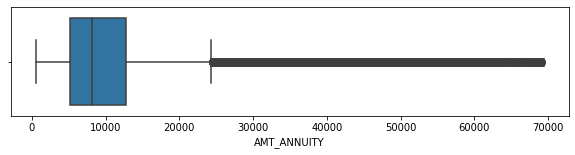

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


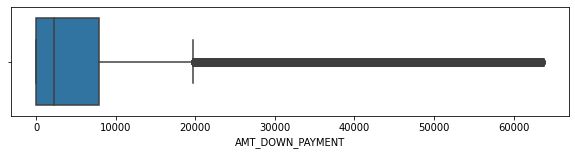

In [35]:
plt.figure(figsize=(10,2))
sns.boxplot(prev_ap_merged['AMT_ANNUITY'])
plt.show()
plt.figure(figsize=(10,2))
sns.boxplot(prev_ap_merged['AMT_DOWN_PAYMENT'])
plt.show()

##Checking Data Imbalance in Previous Application Data

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


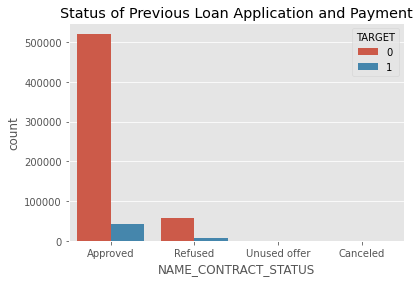

In [36]:
plt.style.use("ggplot")
plt.title("Status of Previous Loan Application and Payment")
sns.countplot(prev_ap_merged['NAME_CONTRACT_STATUS'], hue=prev_ap_merged['TARGET'])
plt.show()

In [37]:
# Percentage of previously approved loan applicants that defaulted in current loan

total_approved = prev_ap_merged[prev_ap_merged['NAME_CONTRACT_STATUS'] == "Approved"].shape[0]
default_approved = prev_ap_merged[(prev_ap_merged['TARGET'] == 1) & (prev_ap_merged['NAME_CONTRACT_STATUS'] == "Approved")].shape[0]

print("Percentage of previously approved loan applicants that defaulted in current loan : ", (default_approved*100/total_approved))

Percentage of previously approved loan applicants that defaulted in current loan :  7.354523610066182


In [38]:
# Percentage of previously refused loan applicants that were able to pay current loan

total_refused = prev_ap_merged[prev_ap_merged['NAME_CONTRACT_STATUS'] == "Refused"].shape[0]
nondefault_refused = prev_ap_merged[(prev_ap_merged['TARGET'] == 0) & (prev_ap_merged['NAME_CONTRACT_STATUS'] == "Refused")].shape[0]

print("Percentage of previously refused loan applicants that were able to pay current loan : ", (nondefault_refused*100/total_refused))

Percentage of previously refused loan applicants that were able to pay current loan :  90.18283846699349


###**Observation**:

* The applicants whose previous loans were approved are more likely to pay current loan in time, than the applicants whose previous loans were rejected.

* 7% of the previously approved loan applicants that defaulted in current loan

* 90 % of the previously refused loan applicants that were able to pay current loan

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


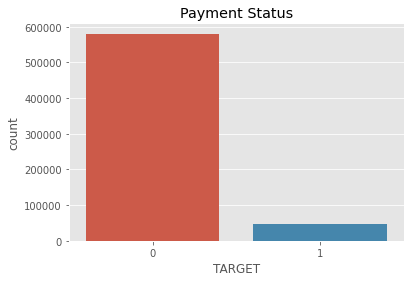

In [39]:
plt.title("Payment Status")
sns.countplot(prev_ap_merged['TARGET'])
plt.show()

###**Insight**: This data is highly imbalanced as number of defaulter is very less in total population.

###Segment 4 and 5: Univariate, Bivariate and Multivariate Analysis

In [41]:
print(prev_ap_merged.FLAG_LAST_APPL_PER_CONTRACT.value_counts())
print(prev_ap_merged.NFLAG_LAST_APPL_IN_DAY.value_counts())

Y    628193
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: int64
1.0    627967
0.0       226
Name: NFLAG_LAST_APPL_IN_DAY, dtype: int64


**Insight**

* 'FLAG_LAST_APPL_PER_CONTRACT' can be dropped for having fixed value in all entries.

* 'NFLAG_LAST_APPL_IN_DAY' can be dropped for having highly imbalance data.

###Analysis of Numeric Features of Previous Application Data

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


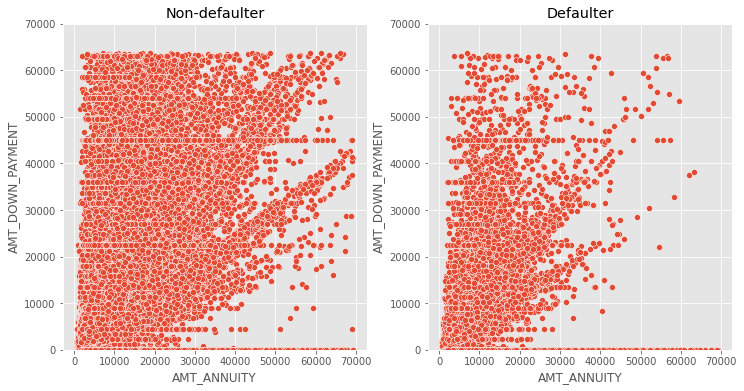

In [42]:
# Setting equal y-limit for both sub-plots for better comparison

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, ylim=(0,70000), title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, ylim=(0,70000), title="Defaulter")

sns.scatterplot(prev_ap_merged[prev_ap_merged["TARGET"] == 0]['AMT_ANNUITY'], prev_ap_merged[prev_ap_merged["TARGET"] == 0]['AMT_DOWN_PAYMENT'], ax=ax1)
sns.scatterplot(prev_ap_merged[prev_ap_merged["TARGET"] == 1]['AMT_ANNUITY'], prev_ap_merged[prev_ap_merged["TARGET"] == 1]['AMT_DOWN_PAYMENT'], ax=ax2)

plt.show()

###**Insight**:

* Number of defaulters are less for larger amount of annuity of previous application.
* For higher down payment, defaulter cases are less.

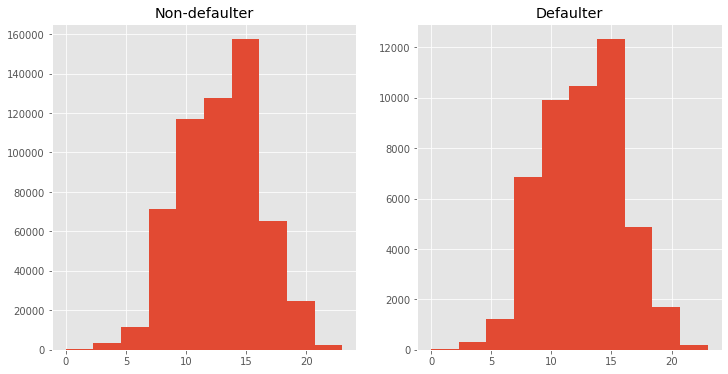

In [43]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

prev_ap_merged[prev_ap_merged["TARGET"] == 0]["HOUR_APPR_PROCESS_START"].hist(bins=10, ax=ax1)
prev_ap_merged[prev_ap_merged["TARGET"] == 1]["HOUR_APPR_PROCESS_START"].hist(bins=10, ax=ax2)

plt.show()

###**Insight**:

* Most of the loans are applied around 15:00 hours. This feature is does not have visible impact on TARGET variable

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


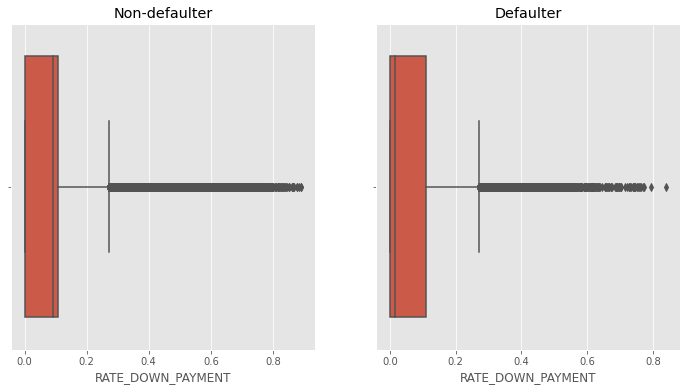

In [60]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="Non-defaulter")
ax2 = fig.add_subplot(1, 2, 2, title="Defaulter")

sns.boxplot(prev_ap_merged[prev_ap_merged["TARGET"] == 0]['RATE_DOWN_PAYMENT'], ax=ax1)
sns.boxplot(prev_ap_merged[prev_ap_merged["TARGET"] == 1]['RATE_DOWN_PAYMENT'], ax=ax2)

plt.show()

####Checking the quantile values for exact percentile

In [45]:
# Percentile of RATE_DOWN_PAYMENT for non-defaulters

prev_ap_merged[prev_ap_merged["TARGET"] == 0]['RATE_DOWN_PAYMENT'].quantile([0.5, 0.7, 0.9, 0.95, 0.99])

0.50    0.091255
0.70    0.108909
0.90    0.211895
0.95    0.282832
0.99    0.498074
Name: RATE_DOWN_PAYMENT, dtype: float64

In [46]:
# Percentile of RATE_DOWN_PAYMENT for defaulters

prev_ap_merged[prev_ap_merged["TARGET"] == 1]['RATE_DOWN_PAYMENT'].quantile([0.5, 0.7, 0.9, 0.95, 0.99])

0.50    0.017238
0.70    0.104260
0.90    0.199685
0.95    0.232643
0.99    0.454294
Name: RATE_DOWN_PAYMENT, dtype: float64

###**Insight**:

* For those who had lower rate of down payment in previous application, cases of default are higher.

###Analysis of Categorical Features of Previous Application Data

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


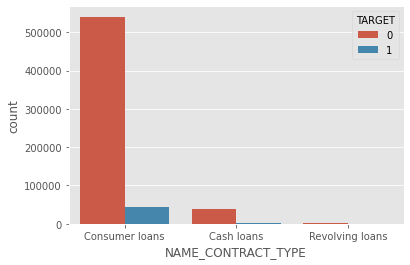

In [47]:
sns.countplot(prev_ap_merged.NAME_CONTRACT_TYPE, hue=prev_ap_merged.TARGET)
plt.show()

###**Insights**:

* Highest number of loans are applied for Consumer Loans

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


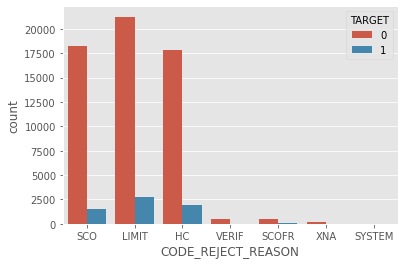

In [48]:
sns.countplot(prev_ap_merged[prev_ap_merged['NAME_CONTRACT_STATUS'] == "Refused"]["CODE_REJECT_REASON"], hue=prev_ap_merged.TARGET)
plt.show()

**Insight**:
*As seen in the above plot, 'SCO', 'LIMIT' and 'HC' are the most common reason of rejection.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


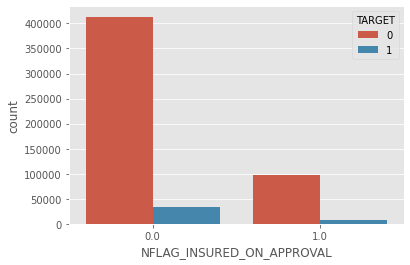

In [49]:
sns.countplot(prev_ap_merged['NFLAG_INSURED_ON_APPROVAL'], hue=prev_ap_merged['TARGET'])
plt.show()

###Insight

*Most of the people did not request insurance during previous loan application.


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


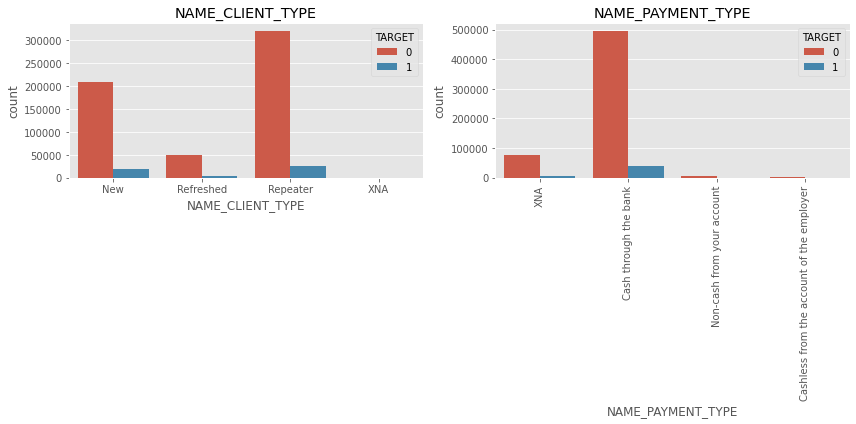

In [50]:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(1, 2, 1, title="NAME_CLIENT_TYPE")
ax2 = fig.add_subplot(1, 2, 2, title="NAME_PAYMENT_TYPE")

sns.countplot(prev_ap_merged['NAME_CLIENT_TYPE'], hue=prev_ap_merged['TARGET'], ax=ax1)
sns.countplot(prev_ap_merged['NAME_PAYMENT_TYPE'], hue=prev_ap_merged['TARGET'], ax=ax2)
plt.xticks(rotation=90)

plt.tight_layout()

plt.show()

###**Insight**:

* Most of the applicants are repeater.
* 'Cash through the bank' is the most frequently used payment method

In [51]:
# This gives percentage of defaulter in total applicants having the same label of the category.
# For example: In 100 applicants, whose'NAME_GOODS_CATEGORY' is Insurance
# approx. 10 people have payment difficulty

def value_wise_defaulter_percentage(df, col):
    new_df = pd.DataFrame(columns=['Value', 'Percentage of Defaulter'])
    
    for value in df[col].unique():
        default_cnt = df[(df[col] == value) & (df.TARGET == 1)].shape[0]
        total_cnt = df[df[col] == value].shape[0]
        new_df = new_df.append({'Value' : value , 'Percentage of Defaulter' : (default_cnt*100/total_cnt)}, ignore_index=True)
    return new_df.sort_values(by='Percentage of Defaulter', ascending=False)

In [52]:
value_wise_defaulter_percentage(prev_ap_merged, 'NAME_GOODS_CATEGORY')

,Value,Percentage of Defaulter
23,Insurance,10.526316
0,Vehicles,10.257410
14,Jewelry,9.124951
17,Auto Accessories,9.029763
3,Mobile,8.615336
15,Office Appliances,8.307692
8,Computers,8.074335
20,Weapon,8.064516
21,Direct Sales,8.024691
5,Audio/Video,7.698706


###**Insight**:

* Highest percentage of default cases are for the applicants who previously applied for Insurance and Vehicles

In [53]:
value_wise_defaulter_percentage(prev_ap_merged, 'NAME_PORTFOLIO')

,Value,Percentage of Defaulter
2,Cards,17.119695
0,POS,7.666139
1,Cash,6.384448
3,Cars,0.000000


###**Insight**: For Cards defaulter rate is highest.

In [54]:

value_wise_defaulter_percentage(prev_ap_merged, 'NAME_PRODUCT_TYPE')

,Value,Percentage of Defaulter
1,walk-in,9.165550
0,XNA,7.665995
2,x-sell,6.036420


###**Insight**:

* From all the walk-in applicants 9% defaulted in current loan.

In [55]:
value_wise_defaulter_percentage(prev_ap_merged, 'CHANNEL_TYPE')

,Value,Percentage of Defaulter
4,AP+ (Cash loan),15.000000
1,Country-wide,7.908171
2,Regional / Local,7.551291
0,Stone,7.294692
3,Credit and cash offices,6.124197
5,Contact center,4.545455
6,Car dealer,0.000000


###**Insight**:

15% loan applicatiant defaulted for AP+ (Cash Loan)

In [56]:
value_wise_defaulter_percentage(prev_ap_merged, 'NAME_SELLER_INDUSTRY')

,Value,Percentage of Defaulter
0,Auto technology,10.522088
9,Jewelry,9.019221
3,Connectivity,8.780637
2,Consumer electronics,7.451983
7,Industry,7.211664
4,Construction,6.597424
5,XNA,6.226598
1,Furniture,5.924492
6,Clothing,5.857399
8,Tourism,4.778157


**Insight**:

* In seller Industry "Auto technology" has highest rate of defaulter
* MLM partners has lowest number of defaulters

In [57]:
value_wise_defaulter_percentage(prev_ap_merged, 'NAME_YIELD_GROUP')

,Value,Percentage of Defaulter
4,XNA,17.119695
2,high,8.340935
1,middle,7.558098
0,low_normal,6.844973
3,low_action,6.608936


**Insight**:

* Defaulter percentage is highest where NAME_YIELD_GROUP is not known.

In [58]:
value_wise_defaulter_percentage(prev_ap_merged, 'PRODUCT_COMBINATION')

,Value,Percentage of Defaulter
13,Card Street,17.195005
4,POS mobile with interest,8.761056
0,POS other with interest,7.953141
3,POS mobile without interest,7.888514
2,POS household with interest,7.752151
11,POS others without interest,7.256127
15,Card X-Sell,6.666667
5,POS household without interest,6.649376
9,Cash Street: middle,6.475391
10,Cash Street: high,6.417625


**Insight**: Highest percentage of default cases is for Card Street